# California Housing Prices - Prediction with Geospatial Feature Engineering
The goal of this project is to improve the accuracy of housing price predictions by analyzing geospatial data  
The project compares a basic machine learning model with more complex models that consider factors such as distance to major population centers, regional population density, and regional clusters  
The effectiveness of each model is evaluated using cross-validation, and the results are compared to identify the most suitable model

## Data Loading and Overview
The dataset is loaded and checked to understand its structure, feature types, and target variable  
Basic checks include the shape of the dataset, missing values, and summary statistics of the target variable  

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import BallTree
from sklearn.cluster import KMeans
from shapely.geometry import Point
from xgboost import XGBRegressor

df = pd.read_csv("C:\\Users\\lb_20\\Downloads\\housing.csv")

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
print("Shape:", df.shape)
print("\nMissing values:", df.isna().sum(), sep = "\n")
print("\nTraget(median house value) describe:", df["median_house_value"].describe(), sep = "\n")

Shape: (20640, 10)

Missing values:
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

Traget(median house value) describe:
count     20640.000000
mean     206855.816909
std      115395.615874
min       14999.000000
25%      119600.000000
50%      179700.000000
75%      264725.000000
max      500001.000000
Name: median_house_value, dtype: float64


## Target Distribution
The distribution of the target variable "median_house_value" is visualized to understand its shape and range  
The visible upper bound represents the limit of the target value present in the dataset  

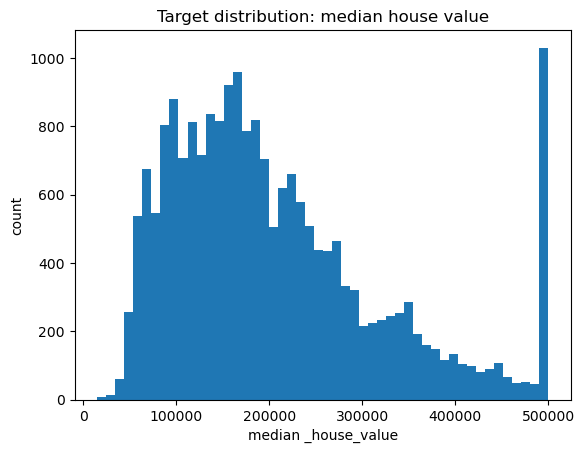

In [6]:
plt.figure()
plt.hist(df["median_house_value"], bins = 50)
plt.title("Target distribution: median house value")
plt.xlabel("median _house_value")
plt.ylabel("count")
plt.show()

## Spatial Distribution of House Prices
Housing prices are displayed on a map with longitude and latitude coordinates to reveal spatial patterns  
This helps confirm that location plays a significant role in price variations

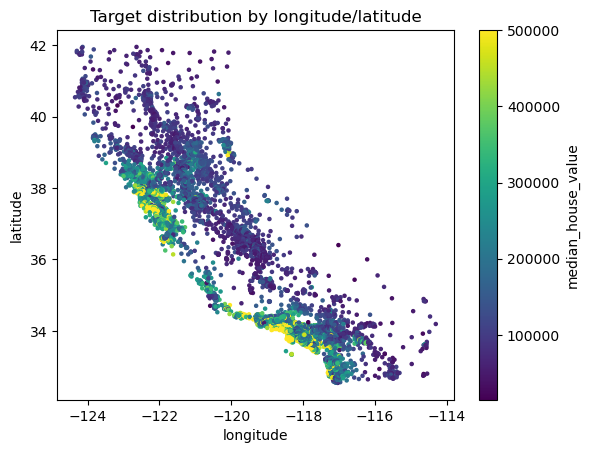

In [8]:
plt.figure()
sc = plt.scatter( df["longitude"], df["latitude"], s=5, c = df["median_house_value"])
plt.title("Target distribution by longitude/latitude")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.colorbar(sc, label = "median_house_value")
plt.show()

## Baseline Feature Setup
The features are divided into two groups: numerical and categorical  
This organization enables consistent preprocessing of data using a single machine learning pipeline

In [10]:
y = df["median_house_value"]
X_base = df.drop(columns = ["median_house_value"])

num_cols_base = X_base.select_dtypes(include = [np.number]).columns.tolist()
cat_cols_base = [c for c in X_base.columns if c not in num_cols_base]

print("Baseline numeric cols:", num_cols_base)
print("Baseline categorical cols:", cat_cols_base)

Baseline numeric cols: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
Baseline categorical cols: ['ocean_proximity']


## Baseline Model (Random Forest)
The Random Forest regression model is used as the base model  
Preprocessing includes imputation, scaling for numerical features, and one-hot encoding for categorical features  
The base model is evaluated on a separate validation set using MAE and RMSE metrics  

In [12]:
numeric_transformer = Pipeline(steps = [("imputer", SimpleImputer(strategy = "median")),
                                        ("scaler", StandardScaler())])

categorical_transformer = Pipeline(steps = [("imputer", SimpleImputer(strategy = "most_frequent")),
                                            ("onehot", OneHotEncoder(handle_unknown = "ignore"))])

preprocessor_base = ColumnTransformer(transformers = [("num", numeric_transformer, num_cols_base),
                                                      ("cat", categorical_transformer, cat_cols_base)])

baseline_model = RandomForestRegressor(n_estimators = 400, random_state = 0, n_jobs = -1)

baseline_pipeline = Pipeline(steps = [("preprocessor", preprocessor_base), ("model", baseline_model)])

X_train_base, X_valid_base, y_train_base, y_valid_base = train_test_split(X_base, y, test_size = 0.2, random_state = 0)

baseline_pipeline.fit(X_train_base, y_train_base)
baseline_preds = baseline_pipeline.predict(X_valid_base)

baseline_mae = mean_absolute_error(y_valid_base, baseline_preds)
baseline_rmse = root_mean_squared_error(y_valid_base, baseline_preds)

print("Baseline MAE:", baseline_mae)
print("Baseline RMSE:", baseline_rmse)

Baseline MAE: 31335.02093568314
Baseline RMSE: 47759.588594873865


## Distance Feature Analysis
Geographic coordinates are converted into a projected coordinate system to enable distance-based calculations  
Distance distributions are plotted to check that the values are realistic and well distributed  
These features capture how close each house is to major cities 

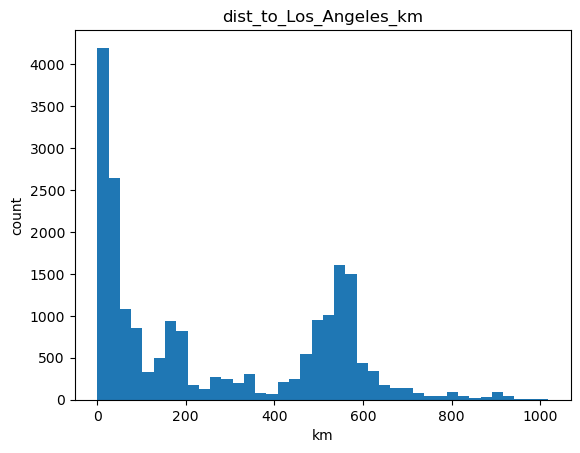

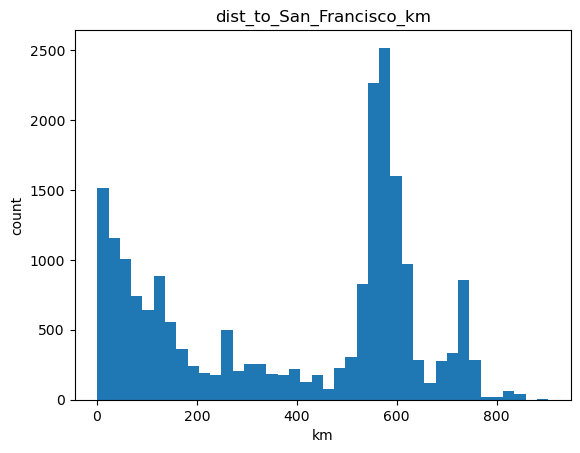

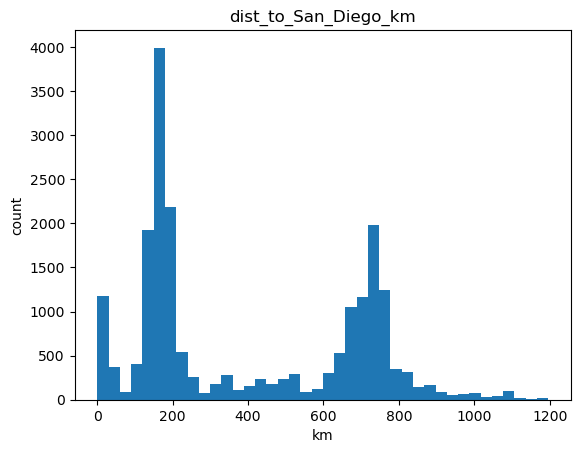

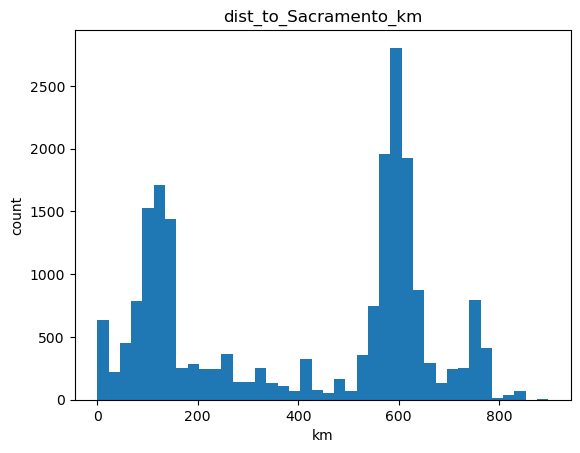

In [14]:
gdf = gpd.GeoDataFrame(df.copy(), geometry = gpd.points_from_xy(df.longitude, df.latitude), crs = "EPSG: 4326")
gdf_m = gdf.to_crs(epsg = 3310)

gdf_m["x_m"] = gdf_m.geometry.x
gdf_m["y_m"] = gdf_m.geometry.y

cities = {"Los_Angeles": (-118.2437, 34.0522),
          "San_Francisco": (-122.4194, 37.7749),
          "San_Diego": (-117.1647, 32.7157),
          "Sacramento": (-121.4899, 38.5906)}
cities_gdf = gpd.GeoDataFrame({"city": list(cities.keys())},
                               geometry = [Point(lon, lat) for lon, lat in cities.values()],
                               crs = "EPSG:4326").to_crs(gdf_m.crs)
for idx, row in cities_gdf.iterrows():
    city = row["city"]
    gdf_m[f"dist_to_{city}_km"] = gdf_m.geometry.distance(row.geometry) / 1000.0

for city in cities.keys():
    col = f"dist_to_{city}_km"
    plt.figure()
    plt.hist(gdf_m[col].dropna(), bins = 40)
    plt.title(col)
    plt.xlabel("km")
    plt.ylabel("count")
    plt.show()

## Neighborhood Density
Density is calculated based on the number of neighbors within various radius ranges  
These characteristics represent the local urban structure at various spatial scales

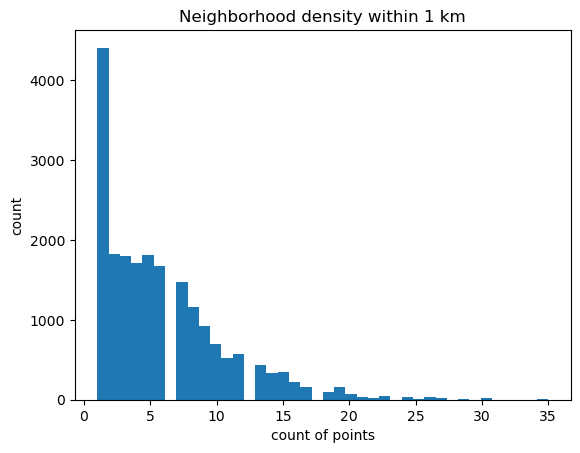

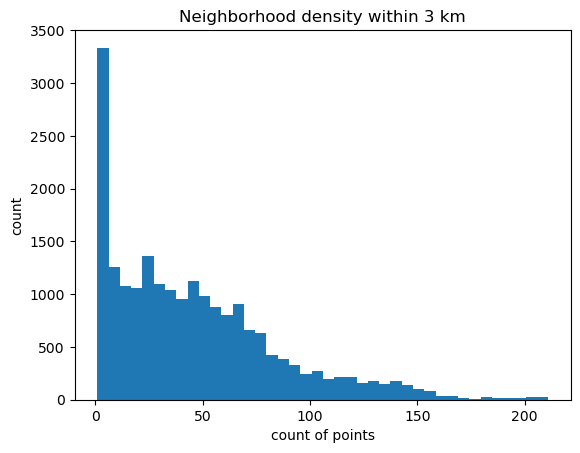

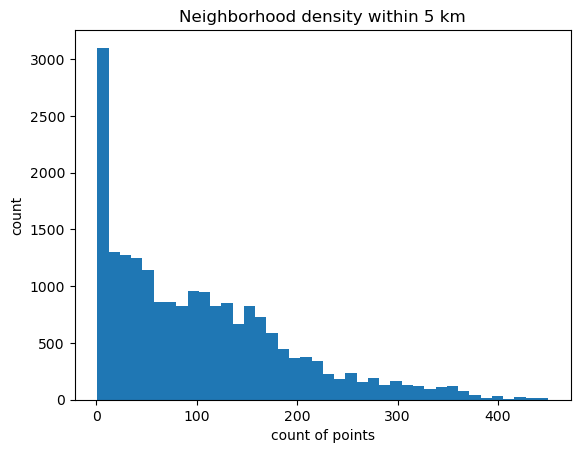

In [16]:
coords = np.vstack([gdf_m["x_m"].values, gdf_m["y_m"].values]).T
tree = BallTree(coords, metric = "euclidean")

for radius_m in [1000, 3000, 5000]:
    col = f"density_{radius_m//1000}km"
    gdf_m[col] = tree.query_radius(coords, r = radius_m, count_only = True)

    plt.figure()
    plt.hist(gdf_m[col].dropna(), bins = 40)
    plt.title(f"Neighborhood density within {radius_m//1000} km")
    plt.xlabel("count of points")
    plt.ylabel("count")
    plt.show()

## Regional Clustering
KMeans clustering is applied to the projected coordinates to identify common geographic regions  
The resulting cluster labels are used as categorical features to reflect regional effects

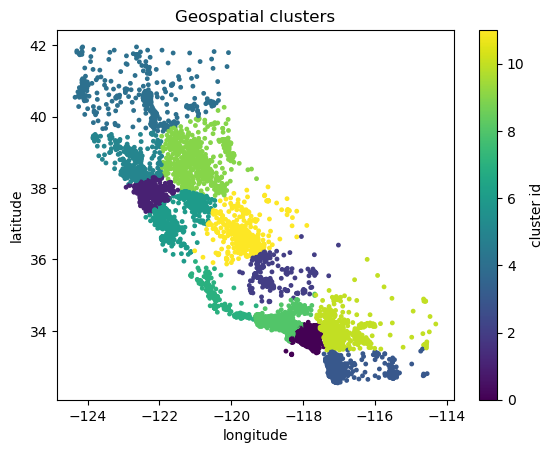

In [18]:
kmeans = KMeans(n_clusters = 12, random_state = 0, n_init = "auto")
gdf_m["geo_cluster"] = kmeans.fit_predict(gdf_m[["x_m", "y_m"]])

plt.figure()
sc2 = plt.scatter(gdf["longitude"], gdf["latitude"], s = 6, c = gdf_m["geo_cluster"])
plt.title("Geospatial clusters")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.colorbar(sc2, label = "cluster id")
plt.show()

## Enhanced Geospatial Model
The base model is retrained using an expanded feature set that includes geospatial features  
Performance is compared against the base model 

In [20]:
features_geo = gdf_m.drop(columns = ["median_house_value", "geometry"]).copy()
target_geo = gdf_m["median_house_value"].copy()

if "geo_cluster" in features_geo.columns:
    features_geo["geo_cluster"] = features_geo["geo_cluster"].astype("category")

num_cols_geo = features_geo.select_dtypes(include = [np.number]).columns.tolist()
cat_cols_geo = [c for c in features_geo.columns if c not in num_cols_geo]

print("With-geo numeric cols:", num_cols_geo)
print("With-geo categorical cols:", cat_cols_geo)

With-geo numeric cols: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'x_m', 'y_m', 'dist_to_Los_Angeles_km', 'dist_to_San_Francisco_km', 'dist_to_San_Diego_km', 'dist_to_Sacramento_km', 'density_1km', 'density_3km', 'density_5km']
With-geo categorical cols: ['ocean_proximity', 'geo_cluster']


In [21]:
preprocessor_geo = ColumnTransformer(transformers = [("num", numeric_transformer, num_cols_geo),
                                                     ("cat", categorical_transformer, cat_cols_geo)])

geo_rf_model = RandomForestRegressor(n_estimators = 600, random_state = 0, n_jobs = -1)

geo_rf_pipeline = Pipeline(steps = [("preprocessor", preprocessor_geo), ("model", geo_rf_model)])

X_train_geo, X_valid_geo, y_train_geo, y_valid_geo = train_test_split(features_geo, target_geo, test_size = 0.2, random_state = 0)

geo_rf_pipeline.fit(X_train_geo, y_train_geo)
geo_rf_preds = geo_rf_pipeline.predict(X_valid_geo)

geo_rf_mae = mean_absolute_error(y_valid_geo, geo_rf_preds)
geo_rf_rmse = root_mean_squared_error(y_valid_geo, geo_rf_preds)

print("Geo RF MAE:", geo_rf_mae)
print("Geo RF RMSE:", geo_rf_rmse)

Geo RF MAE: 29358.485321786175
Geo RF RMSE: 45734.8612528627


## Single-Split Comparison
The model's performance before and after adding geospatial features is compared on the same validation split

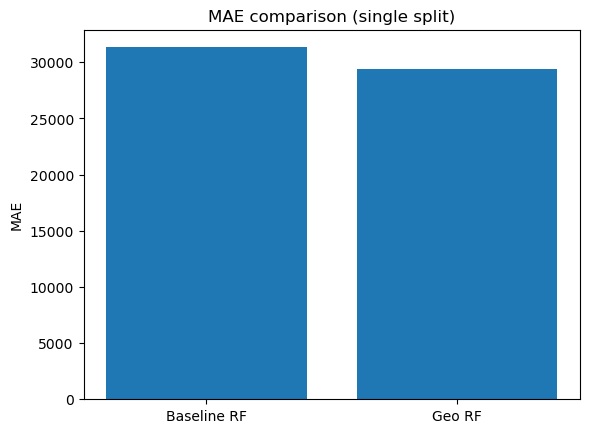

In [23]:
plt.figure()
plt.bar(["Baseline RF", "Geo RF"], [baseline_mae, geo_rf_mae])
plt.title("MAE comparison (single split)")
plt.ylabel("MAE")
plt.show()

In [24]:
improvement_pct_split = (baseline_mae - geo_rf_mae) / baseline_mae * 100.0
print(f"\nSplit-based MAE improvement (Geo RF vs Baseline RF): {improvement_pct_split:.2f}%")


Split-based MAE improvement (Geo RF vs Baseline RF): 6.31%


## Cross-Validation Strategy
K-Fold cross-validation is used to obtain a more accurate assessment of model performance  
Both MAE and RMSE are evaluated across multiple folds

In [26]:
numeric_prep_cv = Pipeline(steps = [("imputer", SimpleImputer(strategy = "median"))])
categorical_prep_cv = Pipeline(steps = [("imputer", SimpleImputer(strategy = "most_frequent")),
                                        ("onehot", OneHotEncoder(handle_unknown = "ignore"))])

preprocessor_cv = ColumnTransformer(transformers = [("num", numeric_prep_cv, num_cols_geo),
                                             ("cat", categorical_prep_cv, cat_cols_geo)])


rf_cv_model = RandomForestRegressor(n_estimators = 900, random_state = 0, n_jobs = -1)

xgb_model = XGBRegressor(objective = "reg:squarederror",
                         n_estimators = 1200,
                         learning_rate = 0.03,
                         max_depth = 6,
                         subsample = 0.9,
                         colsample_bytree = 0.9,
                         reg_lambda = 1.0,
                         random_state = 0,
                         n_jobs = -1)

rf_cv_pipeline = Pipeline(steps = [("preprocessor", preprocessor_cv), ("model", rf_cv_model)])

xgb_pipeline = Pipeline(steps = [("preprocessor", preprocessor_cv), ("model", xgb_model)])

cv = KFold(n_splits = 5, shuffle = True, random_state = 0)

scoring = {"mae": "neg_mean_absolute_error",
           "rmse": "neg_root_mean_squared_error"}

rf_cv = cross_validate(rf_cv_pipeline, features_geo, target_geo, 
                       cv = cv,
                       scoring = scoring,
                       n_jobs = -1,
                       return_train_score = False)

rf_mae = -rf_cv["test_mae"]
rf_rmse = -rf_cv["test_rmse"]

print("RF (Geo) CV results")
print("MAE  folds:", np.round(rf_mae, 2))
print("MAE  mean :", rf_mae.mean(), "std:", rf_mae.std())
print("RMSE folds:", np.round(rf_rmse, 2))
print("RMSE mean :", rf_rmse.mean(), "std:", rf_rmse.std())

RF (Geo) CV results
MAE  folds: [29320.91 29458.92 29156.04 29442.24 29039.  ]
MAE  mean : 29283.42051981051 std: 163.33711222604694
RMSE folds: [45684.22 47056.04 46547.11 46095.25 44760.57]
RMSE mean : 46028.63682507887 std: 781.715988209738


In [27]:
xgb_cv = cross_validate(xgb_pipeline, features_geo, target_geo, 
                        cv = cv, 
                        scoring = scoring, 
                        n_jobs = -1, 
                        return_train_score = False)

xgb_mae = -xgb_cv["test_mae"]
xgb_rmse = -xgb_cv["test_rmse"]

print("XGB (Geo) CV results")
print("MAE  folds:", np.round(xgb_mae, 2))
print("MAE  mean :", xgb_mae.mean(), "std:", xgb_mae.std())
print("RMSE folds:", np.round(xgb_rmse, 2))
print("RMSE mean :", xgb_rmse.mean(), "std:", xgb_rmse.std())

XGB (Geo) CV results
MAE  folds: [27334.27 27827.03 27509.2  27703.14 27807.86]
MAE  mean : 27636.299354825274 std: 188.49569964670908
RMSE folds: [41591.65 43748.07 43388.39 43328.94 42561.25]
RMSE mean : 42923.658424112095 std: 770.1235393407734


## Model Comparison: Random Forest vs XGBoost
The Random Forest and XGBoost models are compared using the same preprocessing pipeline and cross-validation settings  
This makes it possible to do a fair and consistent comparison of the models

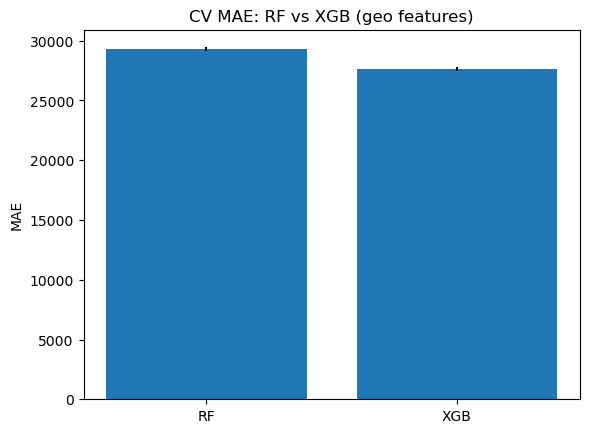

In [29]:
labels = ["RF", "XGB"]

mae_means = [rf_mae.mean(), xgb_mae.mean()]
mae_stds  = [rf_mae.std(),  xgb_mae.std()]

rmse_means = [rf_rmse.mean(), xgb_rmse.mean()]
rmse_stds  = [rf_rmse.std(),  xgb_rmse.std()]

plt.figure()
plt.bar(labels, mae_means, yerr = mae_stds)
plt.title("CV MAE: RF vs XGB (geo features)")
plt.ylabel("MAE")
plt.show()

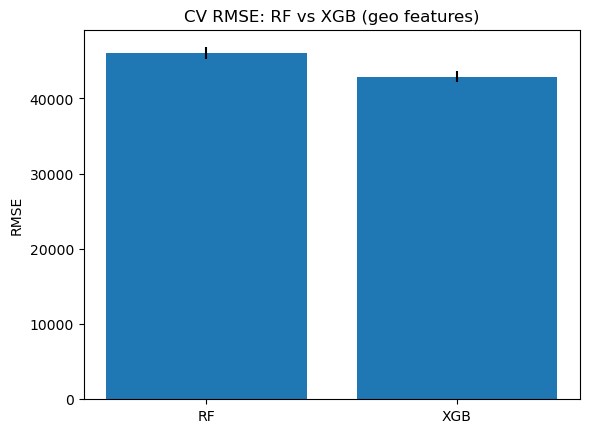

In [30]:
plt.figure()
plt.bar(labels, rmse_means, yerr = rmse_stds)
plt.title("CV RMSE: RF vs XGB (geo features)")
plt.ylabel("RMSE")
plt.show()

## Final Results Summary
The effectiveness of the model is summarized in a comparative table 
The results show that geospatial characteristics and gradient boosting provide a significant improvement over the baseline 

In [32]:
mae_impr = (mae_means[0] - mae_means[1]) / mae_means[0] * 100.0
rmse_impr = (rmse_means[0] - rmse_means[1]) / rmse_means[0] * 100.0

print("Improvement (XGB vs RF, CV mean):")
print(f"MAE  improvement: {mae_impr:.2f}%")
print(f"RMSE improvement: {rmse_impr:.2f}%")

Improvement (XGB vs RF, CV mean):
MAE  improvement: 5.62%
RMSE improvement: 6.75%


In [33]:
summary = pd.DataFrame({"Model": ["Baseline RF (single split)", "Geo RF (single split)", "Geo RF (CV mean)", "Geo XGB (CV mean)"],
                        "MAE": [baseline_mae, geo_rf_mae, rf_mae.mean(), xgb_mae.mean()],
                        "RMSE": [baseline_rmse, geo_rf_rmse, rf_rmse.mean(), xgb_rmse.mean()]})

display(summary)

,Model,MAE,RMSE
0,Baseline RF (single split),31335.020936,47759.588595
1,Geo RF (single split),29358.485322,45734.861253
2,Geo RF (CV mean),29283.420520,46028.636825
3,Geo XGB (CV mean),27636.299355,42923.658424
